In [1]:
# cording = UTF-8
import os,re,random,copy                    #標準ライブラリ
import scipy,librosa,sklearn,joblib,h5py    #サードパーティライブラリ
import numpy as np
import pandas as pd                         #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras                #御呪い
import matplotlib.pyplot as plt

print ("Scipy version:{0}".format(scipy.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Tensorflow version:{0}".format(tf.__version__)) #赤線は無視
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("joblib version:{0}".format(joblib.__version__))
print ("h5py version:{0}".format(h5py.__version__))


Scipy version:1.4.1
Numpy version:1.18.2
Pandas version:1.0.3
Tensorflow version:2.1.0
tf.keras version:2.2.4-tf
Scikit-Learn version:0.22.2.post1
joblib version:0.14.1
h5py version:2.10.0


In [2]:
batch_size = 256         #オフライン学習時のバッチサイズ
epochs = 20            #学習時のエポック数(グリッドサーチ時は無効)
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標
encode_dim = 1600        #オートエンコーダの圧縮次元

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")

#学習用データファイル
datafile = "dataset2.npz"

#dデータロードから前処理まで
load_data = np.load(os.path.join(data_dir,datafile))
X_data =load_data['X']
y_data = load_data['y']
del load_data
print("Data loaded!!")

X_shape = X_data.shape[1:]  #データの形状を取得

#データ前処理 trainとtestを分離
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = \
    train_test_split(
        X_data.reshape(len(X_data),-1), #アフィン変換
        y_data,
        test_size=0.05)
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)
del X_data,y_data

#X_trainからOKデータ(False)だけを抽出する
X_train_ae = X_train[np.logical_not(y_train)]
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)


Data loaded!!
Training data amounts :3800
Test data amounts :200
X_train for Autoencoder was splited!!
amount/shape:(1904, 60021)


In [3]:
#AE定義
def ae(input_dim,encode_dim,lr,alpha,dr_rate,hidden_act,out_act,loss):

    input_data = tf.keras.layers.Input(shape = (input_dim,))

    #エンコーダを定義
    encoder = tf.keras.layers.Dense(
        encode_dim,
        kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.l2(alpha),
        )(input_data)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Dropout(dr_rate)(encoder)
    encoder = tf.keras.layers.Activation(hidden_act)(encoder)

    #デコーダを定義 こっちにはドロップアウトは定義しない
    decoder = tf.keras.layers.Dense(
        input_dim,kernel_initializer="he_normal")(encoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation(out_act)(decoder)

    #モデルを定義
    autoencoder = tf.keras.Model(
        inputs = input_data,
        outputs = decoder
    )

    #最適化関数
    opt = tf.keras.optimizers.Nadam(lr = lr)

    autoencoder.compile(
        optimizer = opt,loss=loss,metrics=['accuracy']
        )

    return autoencoder

cb_es = tf.keras.callbacks.EarlyStopping(
    monitor = monitor,patience=3,min_delta = 0.0001
    )


In [4]:
#パラメータの設定
lr = 1e-01               #初期学習率
alpha = 0               #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
hidden_act = "relu"
out_act = "sigmoid"
loss = "binary_crossentropy"


Train on 1808 samples, validate on 96 samples
Epoch 1/20
1808/1808 [==============================] - 44s 25ms/sample - loss: 0.5809 - accuracy: 2.7645e-08 - val_loss: 0.4381 - val_accuracy: 0.0000e+00
Epoch 2/20
1808/1808 [==============================] - 39s 22ms/sample - loss: 0.3687 - accuracy: 2.7645e-08 - val_loss: 0.2723 - val_accuracy: 0.0000e+00
Epoch 3/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.2296 - accuracy: 2.7645e-08 - val_loss: 0.1730 - val_accuracy: 0.0000e+00
Epoch 4/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.1490 - accuracy: 2.7645e-08 - val_loss: 0.1172 - val_accuracy: 0.0000e+00
Epoch 5/20
1808/1808 [==============================] - 44s 24ms/sample - loss: 0.1033 - accuracy: 2.7645e-08 - val_loss: 0.0848 - val_accuracy: 0.0000e+00
Epoch 6/20
1808/1808 [==============================] - 42s 23ms/sample - loss: 0.0763 - accuracy: 2.7645e-08 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 7/20
1808/18

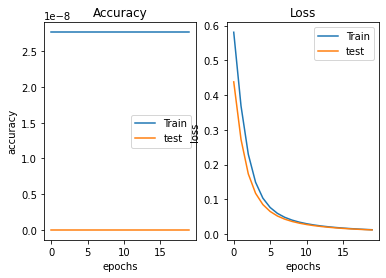

Prediction is finished!!


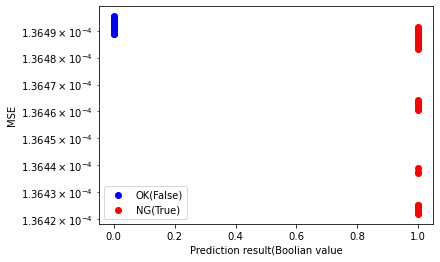

In [5]:
#学習させる
model = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate,
    hidden_act="relu",
    out_act="sigmoid",
    loss = "binary_crossentropy"
)

hist = model.fit(
    X_train_ae,X_train_ae,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [cb_es], #,cb_rd,cb_tb うまく動かない
    validation_split = 0.05,
    shuffle = True,
    use_multiprocessing=True
)

#学習曲線の表示
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Loss")

plt.show()

#推論を行う
X_decode = model.predict(X_test)
print ("Prediction is finished!!")

#MSEを計算
diff_mse = np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_mse[i] = sklearn.metrics.mean_squared_error(
        X_test[i],X_decode[i])
#可視化
plt.scatter(
    y_test[np.logical_not(y_test)],
    diff_mse[np.logical_not(y_test)],
    color = "#0000ff",
    linestyle='None',
    label = "OK(False)"
    )
plt.scatter(
    y_test[y_test],
    diff_mse[y_test],
    color = "#ff0000",
    linestyle='None',
    label = "NG(True)"
    )
plt.xlabel("Prediction result(Boolian value")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()


In [6]:
#出力関数をリニア、lossを二乗和誤差に変更
lr = 1e-01               #初期学習率
alpha = 0               #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
hidden_act = "relu"
out_act = "linear"
loss = "mean_squared_eroor"

Train on 1808 samples, validate on 96 samples
Epoch 1/20
1808/1808 [==============================] - 44s 24ms/sample - loss: 0.5809 - accuracy: 2.7645e-08 - val_loss: 0.4381 - val_accuracy: 0.0000e+00
Epoch 2/20
1808/1808 [==============================] - 40s 22ms/sample - loss: 0.3687 - accuracy: 2.7645e-08 - val_loss: 0.2723 - val_accuracy: 0.0000e+00
Epoch 3/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.2296 - accuracy: 2.7645e-08 - val_loss: 0.1730 - val_accuracy: 0.0000e+00
Epoch 4/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.1490 - accuracy: 2.7645e-08 - val_loss: 0.1172 - val_accuracy: 0.0000e+00
Epoch 5/20
1808/1808 [==============================] - 40s 22ms/sample - loss: 0.1033 - accuracy: 2.7645e-08 - val_loss: 0.0848 - val_accuracy: 0.0000e+00
Epoch 6/20
1808/1808 [==============================] - 44s 24ms/sample - loss: 0.0763 - accuracy: 2.7645e-08 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 7/20
1808/18

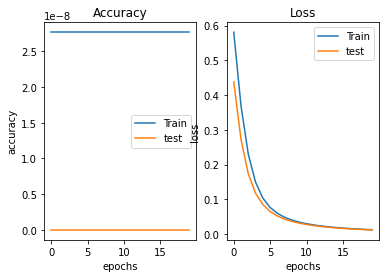

Prediction is finished!!


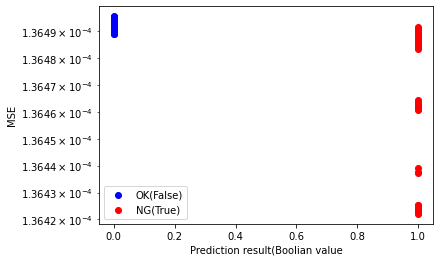

In [7]:
#学習させる
model = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate,
    hidden_act="relu",
    out_act="sigmoid",
    loss = "binary_crossentropy"
)

hist = model.fit(
    X_train_ae,X_train_ae,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [cb_es], #,cb_rd,cb_tb うまく動かない
    validation_split = 0.05,
    shuffle = True,
    use_multiprocessing=True
)

#学習曲線の表示
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Loss")

plt.show()

#推論を行う
X_decode = model.predict(X_test)
print ("Prediction is finished!!")

#MSEを計算
diff_mse = np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_mse[i] = sklearn.metrics.mean_squared_error(
        X_test[i],X_decode[i])
#可視化
plt.scatter(
    y_test[np.logical_not(y_test)],
    diff_mse[np.logical_not(y_test)],
    color = "#0000ff",
    linestyle='None',
    label = "OK(False)"
    )
plt.scatter(
    y_test[y_test],
    diff_mse[y_test],
    color = "#ff0000",
    linestyle='None',
    label = "NG(True)"
    )
plt.xlabel("Prediction result(Boolian value")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()



ほとんど変わらん

In [8]:
#隠れ層の活性化関数をeluに変更
lr = 1e-01               #初期学習率
alpha = 0               #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
hidden_act = "elu"
out_act = "linear"
loss = "mean_squared_eroor"

Train on 1808 samples, validate on 96 samples
Epoch 1/20
1808/1808 [==============================] - 46s 25ms/sample - loss: 0.5809 - accuracy: 2.7645e-08 - val_loss: 0.4381 - val_accuracy: 0.0000e+00
Epoch 2/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.3687 - accuracy: 2.7645e-08 - val_loss: 0.2723 - val_accuracy: 0.0000e+00
Epoch 3/20
1808/1808 [==============================] - 40s 22ms/sample - loss: 0.2296 - accuracy: 2.7645e-08 - val_loss: 0.1730 - val_accuracy: 0.0000e+00
Epoch 4/20
1808/1808 [==============================] - 43s 24ms/sample - loss: 0.1490 - accuracy: 2.7645e-08 - val_loss: 0.1172 - val_accuracy: 0.0000e+00
Epoch 5/20
1808/1808 [==============================] - 44s 24ms/sample - loss: 0.1033 - accuracy: 2.7645e-08 - val_loss: 0.0848 - val_accuracy: 0.0000e+00
Epoch 6/20
1808/1808 [==============================] - 44s 24ms/sample - loss: 0.0763 - accuracy: 2.7645e-08 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 7/20
1808/18

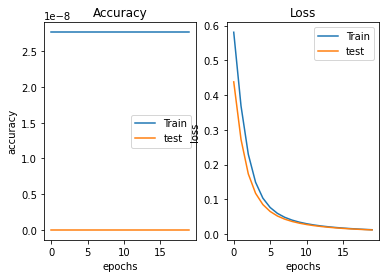

Prediction is finished!!


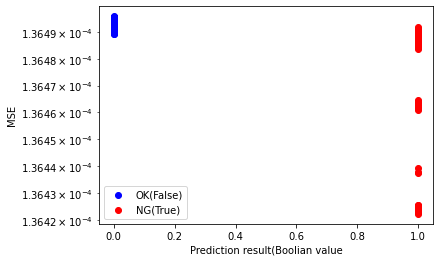

In [9]:
#学習させる
model = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate,
    hidden_act="relu",
    out_act="sigmoid",
    loss = "binary_crossentropy"
)

hist = model.fit(
    X_train_ae,X_train_ae,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [cb_es], #,cb_rd,cb_tb うまく動かない
    validation_split = 0.05,
    shuffle = True,
    use_multiprocessing=True
)

#学習曲線の表示
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","test"])
plt.title("Loss")

plt.show()

#推論を行う
X_decode = model.predict(X_test)
print ("Prediction is finished!!")

#MSEを計算
diff_mse = np.zeros(y_test.shape)
for i in range(X_test.shape[0]):
    diff_mse[i] = sklearn.metrics.mean_squared_error(
        X_test[i],X_decode[i])
#可視化
plt.scatter(
    y_test[np.logical_not(y_test)],
    diff_mse[np.logical_not(y_test)],
    color = "#0000ff",
    linestyle='None',
    label = "OK(False)"
    )
plt.scatter(
    y_test[y_test],
    diff_mse[y_test],
    color = "#ff0000",
    linestyle='None',
    label = "NG(True)"
    )
plt.xlabel("Prediction result(Boolian value")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()



やっぱり変わらん